analysis of md trajectories

0. charm подготовка
1. громакс на сервере
2. этот юпитер

белок RINI_HUMAN P13489 Ribonuclease inhibitor

https://www.uniprot.org/uniprot/P13489



In [1]:
import MDAnalysis as mda
import nglview as nv

In [7]:
model=mda.Universe('gromacs/step5_production.gro','gromacs/step5_production.xtc')

In [8]:
print(len(model.select_atoms('protein')))
print(len(model.select_atoms('name SOD')))
print(len(model.select_atoms('name CLA')))
print(len(model.select_atoms('resname TIP3')))
print(len(model.select_atoms('name CAL')))

6977
84
C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
62
65454
0


In [9]:
view=nv.show_mdanalysis(model)
view

NGLWidget(max_frame=6)

In [10]:
# view.add_spacefill('CAL')
view.add_spacefill('TIP3',opacity=0.05)
view.add_unitcell()

# RMSD fitting and analysis

In [12]:
from MDAnalysis.analysis import rms
import pandas as pd

In [13]:
BACKBONE = 'backbone'
SIDECHAINS = 'not backbone'

In [14]:

#среднее квадр отклонение относительно нулевого кадра 
R = rms.RMSD(model,  # universe to align
             model,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[BACKBONE, SIDECHAINS],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R.run()

In [16]:
df = pd.DataFrame(R.rmsd,
                  columns=['Frame', 'Time (ps)',
                           'Total', 'backbone',
                           'sidechains'])

<AxesSubplot:xlabel='Frame'>

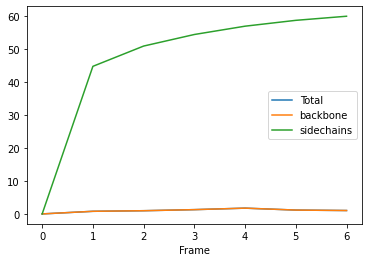

In [17]:
df.plot(x='Frame', y=['Total', 'backbone', 'sidechains'],
             kind='line')

<AxesSubplot:xlabel='Frame'>

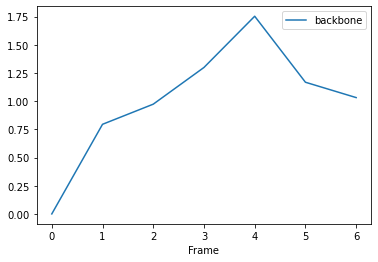

In [18]:
df.plot(x='Frame', y=['backbone'],
             kind='line')

# checking for compactness

In [19]:
prot = model.select_atoms("protein")
Rgyr=[]
for ts in model.trajectory[::1]:
    Rgyr.append(prot.radius_of_gyration())

In [20]:
df['Rgyr']=Rgyr

<AxesSubplot:xlabel='Frame'>

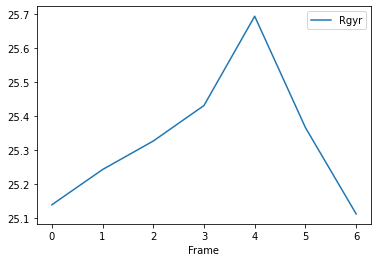

In [21]:
df.plot(x='Frame', y=['Rgyr'],
             kind='line')

# RMSF fitting and analysis

In [22]:
from MDAnalysis.analysis import align

#фиксируем белок
prealigner = align.AlignTraj(model, model, select="protein and name CA",
                             in_memory=True).run()

#rmsfer = RMSF(calphas).run()

C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


In [23]:
view=nv.show_mdanalysis(model)
#убрать воду 
# view.add_spacefill('TIP3',opacity=0.05)
# view.add_spacefill('CAL')

view

NGLWidget(max_frame=6)

In [24]:
#расчёт средне кв флуктуаций

rmsf_runner=rms.RMSF(model.select_atoms('protein and name CA'), verbose=True).run()

C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\core\selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
100%|██████████| 7/7 [00:00<00:00, 3575.27it/s]


In [27]:
seq_3_base=model.select_atoms('protein').residues.resnames

In [28]:
rmsf_result=pd.DataFrame(rmsf_runner.rmsf,index=seq_3_base)

Exception ignored in: <function ReaderBase.__del__ at 0x0000020BEFD9C948>
Traceback (most recent call last):
  File "C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\coordinates\base.py", line 2152, in __del__
    self.close()
  File "C:\Programing\Miniconda\envs\struct_bioinf\lib\site-packages\MDAnalysis\coordinates\XDR.py", line 179, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'


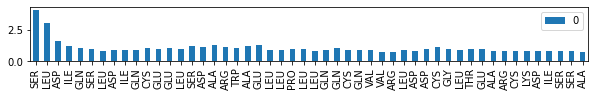

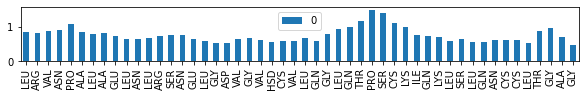

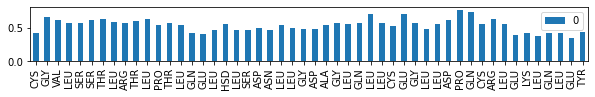

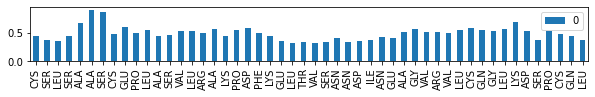

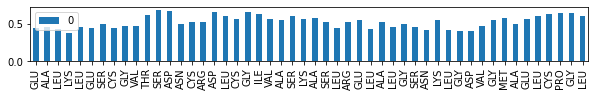

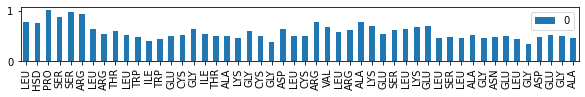

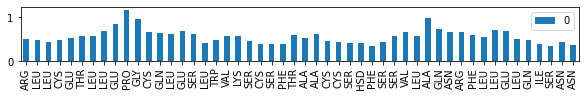

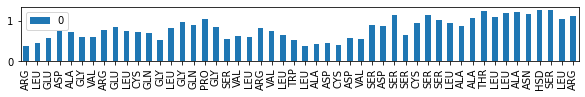

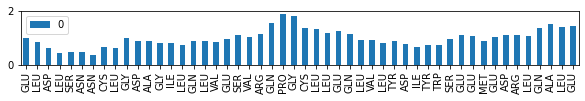

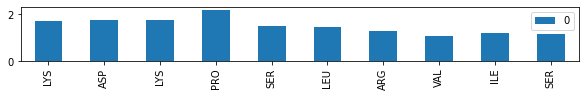

In [29]:
#где подвижность в белке
step=50
for i in range(0,len(seq_3_base),step):
    rmsf_result.iloc[i:i+step].plot(kind='bar',figsize=(10,1))

<AxesSubplot:>

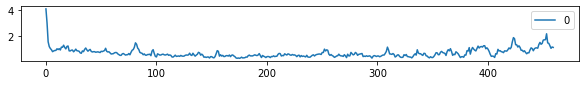

In [30]:
rmsf_result.plot(kind='line',figsize=(10,1),use_index =False)

# visualize RMSF

In [32]:
protein_residues=model.select_atoms('protein').residues
model.add_TopologyAttr('tempfactors')

In [33]:
for residue,RMSF_value in zip(protein_residues,rmsf_runner.rmsf):
    residue.atoms.tempfactors=RMSF_value

In [34]:
view=nv.show_mdanalysis(model)
view

NGLWidget(max_frame=6)

In [36]:
#отображение подвижности петлей
view.update_cartoon(color='bfactor')
view


NGLWidget(frame=6, max_frame=6, n_components=1)


белок RINI_HUMAN P13489 Ribonuclease inhibitor

https://www.uniprot.org/uniprot/P13489


выводы:
- белок малоподвижен, к 6 фрейму снизил скорость  --> либо реально хорошо подобраны параметры и модель, либо надо было моделировать на больший промежуток времени (cpu сервера больше не потянуло gromax за адекватное время), либо и то, и то
- самая подвижная часть -- края, что и логично из-за пружинной формы белка